In [12]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

device = "cuda:1"
model_id = "gpt2-large"
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

/u/sebono/miniconda3/envs/.py311env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import torch

nltk.download('punkt')
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('english'))

# Assuming 'matches', 'dialog', 'offset', and 'perpl' are defined earlier in your code
def perplexity_to_info(dialog, tokens, perpl, answers, pattern = '<(SPK[1-9]|MOD)>'):

    matches = re.findall(pattern, "".join(dialog))
    unique_matches = np.unique(matches)
    #encodings = tokenizer(" ".join(dialog), return_tensors="pt")
    encodings = torch.cat(tokens)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    ppl_to_info = []
    prev_idx_pp = 0
    for idx, (match,answer) in enumerate(zip(matches,answers)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(r'\[([^\]]+)\]: ', '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        ppl_to_info.append({"label":answer, "perpl": np.asarray(perpl_per_sent)})
    
    return ppl_to_info

def filter_out_common_words(words, perpl):
    # Remove stop words and corresponding perplexity values
    filtered_words = [word for word in words if word.lower().strip() not in STOP_WORDS]
    filtered_word_indices = [i for i, word in enumerate(words) if word.lower().strip() not in STOP_WORDS]
    assert len(list(np.asarray(perpl)[filtered_word_indices])) == len(filtered_words)
    return list(np.asarray(perpl)[filtered_word_indices]), filtered_word_indices

def perplexity_to_info_filtering_out_common_words(dialog, tokens, perpl, answers, matches, pattern = '<(SPK[1-9]|MOD)>'):
    
    encodings = torch.cat(tokens)
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    
    ppl_to_info = []
    prev_idx_pp = 0
    dialog_filtered = []
    for idx, (match,answer) in enumerate(zip(matches,answers)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(pattern, '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        assert len(decoded) == len(perpl[prev_idx_pp:idx_pp])
        perpl_per_sent, filtered_word_indices = filter_out_common_words(decoded, perpl[prev_idx_pp:idx_pp])
        assert len(perpl_per_sent) == len(tokens[filtered_word_indices])
        dialog_filtered.append(tokens[filtered_word_indices])
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        ppl_to_info.append({"label":answer, "perpl": np.asarray(perpl_per_sent)})
        
    return dialog_filtered, ppl_to_info

def compute_per_user_mean_perplexity_filtering_out_common_words(dialog, tokens, perpl, matches, pattern = '<(SPK[1-9]|MOD)>'):

    encodings = torch.cat(tokens)
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    prev_idx_pp = 0
    user_to_ppl = {}
    decoded_utterances = []
    for idx, match in enumerate(matches):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(pattern, '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        assert len(decoded) == len(perpl[prev_idx_pp:idx_pp])
        perpl_per_sent, filtered_word_indices = filter_out_common_words(decoded, perpl[prev_idx_pp:idx_pp])
        decoded_utterances.append([tokenizer.decode([token], skip_special_tokens=True) for token in tokens[filtered_word_indices]])
        assert len(perpl_per_sent) == len(tokens[filtered_word_indices])
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        if patt not in user_to_ppl:
            user_to_ppl[patt] = []
        user_to_ppl[patt].append(mean_value)
        
    return user_to_ppl, decoded_utterances

def compute_per_user_mean_perplexity(dialog, tokens, perpl, matches, pattern = '<(SPK[1-9]|MOD)>'):
    
    encodings = torch.cat(tokens)
    #matches = re.findall(pattern, "".join(dialog))
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)


    prev_idx_pp = 0
    user_to_ppl = {}
    for idx in range(len(matches)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        if patt not in user_to_ppl:
            user_to_ppl[patt] = []
        user_to_ppl[patt].append(mean_value)
        
    return  user_to_ppl

import warnings

def compute_per_utterance_mean_perplexity(dialog, tokens, perpl, pattern = '<(SPK[1-9]|MOD)>'):
    
    encodings = torch.cat(tokens)    
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    warnings.filterwarnings("ignore", message="Mean of empty slice")

    pos_nxt_speaker_token = np.asarray([0] + [len(tokenizer(d, return_tensors="pt").input_ids[0]) for d in dialog])[:-1]
    pos_nxt_speaker_token_cumsum = pos_nxt_speaker_token.cumsum()
    bin_edges = np.concatenate([[0], tokens_ids_per_sentence])
    idx_bin = np.digitize(pos_nxt_speaker_token_cumsum, bin_edges) - 1
    
    idx_bin_plu = idx_bin.copy()
    idx_bin_plu = np.asarray(list(idx_bin_plu) + [-1])
    change_indices = np.where(idx_bin_plu[:-1] != idx_bin_plu[1:])[0] + 1
    
    assert len(pos_nxt_speaker_token_cumsum) == len(idx_bin)
    assert len(pos_nxt_speaker_token_cumsum) == len(dialog)

    prev_idx_pp = 1
    utterance_to_ppl = []
    current_sum = 0
    for idx in range(len(tokens)):
        idxs_nxt_speaker_token = pos_nxt_speaker_token_cumsum[np.argwhere(np.isin(idx_bin, idx)).flatten()] - prev_idx_pp
        idx_pp = tokens_ids_per_sentence[idx]
        encodings_ = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in encodings_]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        substring_ppl = [np.nanmean(perpl_per_sent[start:end]) for start, end in zip([0] + list(idxs_nxt_speaker_token), list(idxs_nxt_speaker_token) + [None])]
        substrings_detoken = [encodings_[start:end] for start, end in zip([0] + list(idxs_nxt_speaker_token), list(idxs_nxt_speaker_token) + [None])] 
        utterance_to_ppl.append([substring_ppl[num] for num, s in enumerate(substrings_detoken) if s.numel() != 0])
        prev_idx_pp = idx_pp
    
    assert change_indices[-1] == len(dialog)

    return  utterance_to_ppl, change_indices
    
def compute_graph_perplexity(tokens, p1, p2, matches, pattern = '<(SPK[1-9]|MOD)>', answers=None):
    
    dialog = [tokenizer.decode(token, skip_special_tokens=True) for token in tokens]
    unique_matches = np.unique(matches)
    
    rows = int(np.ceil(np.sqrt(len(dialog))))
    # Create an 8x8 grid of subplots
    fig, axes = plt.subplots(rows, rows, figsize=(30, 30))
    num_plots = len(dialog)
    # Set smaller font size
    plt.rcParams.update({'font.size': 8})
    
    assert num_plots == len(matches)
    encodings = torch.cat(tokens)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(p1)
    
    prev_idx_pp = 0
    for idx, ax in enumerate(axes.flatten()):
        if idx < num_plots:
            idx_pp = tokens_ids_per_sentence[idx]
            patt = matches[idx]
            tokens = encodings[prev_idx_pp:idx_pp]
            decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
            p1_per_sent = p1[prev_idx_pp:idx_pp]
            p2_per_sent = p2[prev_idx_pp:idx_pp]
            ax.plot(np.asarray(p1_per_sent), label=f'{patt} p1')
            ax.plot(np.asarray(p2_per_sent), label=f'{patt} p2', color='r')
            #mean_value=np.nanmean(np.asarray(perpl_per_sent))
            ax.axhline(p1_per_sent[0], color='g', label=f'{patt} p3')  # Fixed the color argument
            ax.set_xticks(np.arange(len(decoded)))
            ax.set_xticklabels(decoded, rotation=90)
            if answers is not None:
                ax.set_title(f'{answers[idx]}')
            ax.legend()
            prev_idx_pp=idx_pp

    # Hide any remaining empty subplots
    for ax in axes.flatten()[num_plots:]:
        ax.axis('off')
        
    plt.subplots_adjust(hspace=0.5, top=0.95)  
    plt.suptitle("Per-Word Perplexity across the Dataset", fontsize=30)
    plt.legend()
    plt.show()

[nltk_data] Downloading package punkt to /u/sebono/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /u/sebono/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### dami2pc

In [14]:
import numpy as np
import re
import pandas as pd

In [15]:
dami2pc_df = pd.read_csv("/u/sebono/conversational_dominance/data/processed/DAMI-P2C/conversations.csv")
dami2pc_df

file_name  \
0   p20_s1_vid_parent_annotation_2019-04-18-14-30-24   
1   p09_s1_vid_parent_annotation_2019-03-16-09-49-32   
2   p06_s1_vid_parent_annotation_2019-03-09-14-18-01   
3   p28_s1_vid_parent_annotation_2019-04-28-14-17-57   
4   p14_s1_vid_parent_annotation_2019-03-23-15-38-30   
..                                               ...   
60  p21_s2_vid_parent_annotation_2019-04-23-16-22-17   
61  p17_s2_vid_parent_annotation_2019-04-07-11-25-21   
62  p17_s1_vid_parent_annotation_2019-03-31-11-22-58   
63  p34_s1_vid_parent_annotation_2019-05-25-09-54-53   
64  p27_s1_vid_parent_annotation_2019-04-28-10-38-25   

                                         file_content  \
0   <SPK3>  Okay. Sure? He's got to make sure ever...   
1   <SPK3> . <SPK0> All right. So now we're going ...   
2   <SPK0>  And then we can start. <SPK0> Okay, gr...   
3   <SPK0> Pats, pets, pet the tree. <SPK2> Swipe ...   
4   <SPK2> The short books. <SPK1> These are the l...   
..                                                ...   
60  <SPK1> I broke my arm. <SPK2> Yeah. <SPK1> I w...   
61  <SPK1> The thing there for your computer. Reme...   
62  <SPK0> So my battery is really getting low. Th...   
63  <SPK1> I read this book once. <SPK2> Yeah. <SP...   
64  <SPK3> Start with the short stories. <SPK3> Do...   

                                            timestamp  
0   2019-04-18 14:30:30;2019-04-18 14:30:45;2019-0...  
1   2019-03-16 09:49:36;2019-03-16 09:49:36;2019-0...  
2   2019-03-09 14:18:05;2019-03-09 14:18:13;2019-0...  
3   2019-04-28 14:18:01;2019-04-28 14:18:02;2019-0...  
4   2019-03-23 15:38:35;2019-03-23 15:38:35;2019-0...  
..                                                ...  
60  2019-04-23 16:22:21;2019-04-23 16:22:25;2019-0...  
61  2019-04-07 11:25:25;2019-04-07 11:25:34;2019-0...  
62  2019-03-31 11:23:19;2019-03-31 11:23:24;2019-0...  
63  2019-05-25 09:54:57;2019-05-25 09:55:06;2019-0...  
64  2019-04-28 10:38:29;2019-04-28 10:38:29;2019-0...  

[65 rows x 3 columns]

In [7]:
# load perplexity
import os
import pickle

p1_dami2pc_path = "/u/sebono/conversational_dominance/notebooks/information_exchange_labelling/dataset_perplexity_results/DAMI-P2C_p1"
perplexity_scores_list = []
perplexity_scores_list_p3 = []
for root, dirs, files in os.walk(p1_dami2pc_path):
    for file in files:
        if file.endswith('.pkl'):
            file_name = file.replace("dominance_scores_","").replace(".pkl","")
            file_path = os.path.join(root, file)
            with open(file_path, 'rb') as f:
                loaded = pickle.load(f)
                perplexity_scores_list.append(loaded)

perplexity_scores_p1 = {k:v for element in perplexity_scores_list for k,v in element.items()}

In [11]:
def create_extended_list(lst, arr):
    result = []
    prev_count = 0
    for i, count in enumerate(arr):
        result.extend([lst[i]] * (count - prev_count))
        prev_count = count
    return result

def compute_p3(dami2pc_df, perplexity_scores_p1):
    perplexity_scores_p3 = {}
    for content, name in zip(dami2pc_df["file_content"], dami2pc_df["file_name"]):
        try:
            pattern = '<(SPK[0-9]|MOD)>'
            matches = re.findall(pattern, "".join(content))
            content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
            content = [re.sub(pattern,">", d) for d in content]
            assert len(perplexity_scores_p1[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
            tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
            assert len(torch.cat(tokens)) == len(perplexity_scores_p1[name])
            tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
            value = np.asarray([0] + list(np.asarray(perplexity_scores_p1[name])[tokens_ids_per_sentence[:-1]]))
            #tokens_value = np.asarray(torch.cat(tokens))[tokens_ids_per_sentence[:-1]]
            perplexity_scores_p3[name] = create_extended_list(value, tokens_ids_per_sentence)
            assert len(perplexity_scores_p3[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
        except:
            print(f'missing {name}')

    return perplexity_scores_p3

In [12]:
dami2pc_df.keys()

Index(['file_name', 'file_content', 'timestamp'], dtype='object')

In [13]:
perplexity_scores_p3 = compute_p3(dami2pc_df, perplexity_scores_p1)

missing p29_s1_vid_parent_annotation_2019-04-28-17-40-11
missing p28_s2_vid_parent_annotation_2019-05-11-14-10-21
missing p22_s2_vid_parent_annotation_2019-04-27-16-52-05
missing p30_s1_vid_parent_annotation_2019-05-10-16-01-49
missing p18_s1_vid_parent_annotation_2019-04-06-09-31-59
missing p25_s1_vid_parent_annotation_2019-04-26-11-27-47
missing p13_s1_vid_parent_annotation_2019-03-23-09-51-08
missing p10_s2_vid_parent_annotation_2019-03-24-13-10-25
missing p14_s2_vid_parent_annotation_2019-03-31-16-34-03
missing p16_s1_vid_parent_annotation_2019-03-30-09-59-12
missing p11_s2_vid_parent_annotation_2019-04-11-15-11-26
missing p07_s1_vid_parent_annotation_2019-03-09-15-46-50
missing p21_s1_vid_parent_annotation_2019-04-13-09-52-16
missing p10_s1_vid_parent_annotation_2019-03-16-11-34-15
missing p11_s1_vid_parent_annotation_2019-03-18-14-23-55
missing p05_s2_vid_parent_annotation_2019-03-17-10-00-28
missing p21_s2_vid_parent_annotation_2019-04-23-16-22-17
missing p17_s2_vid_parent_annot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


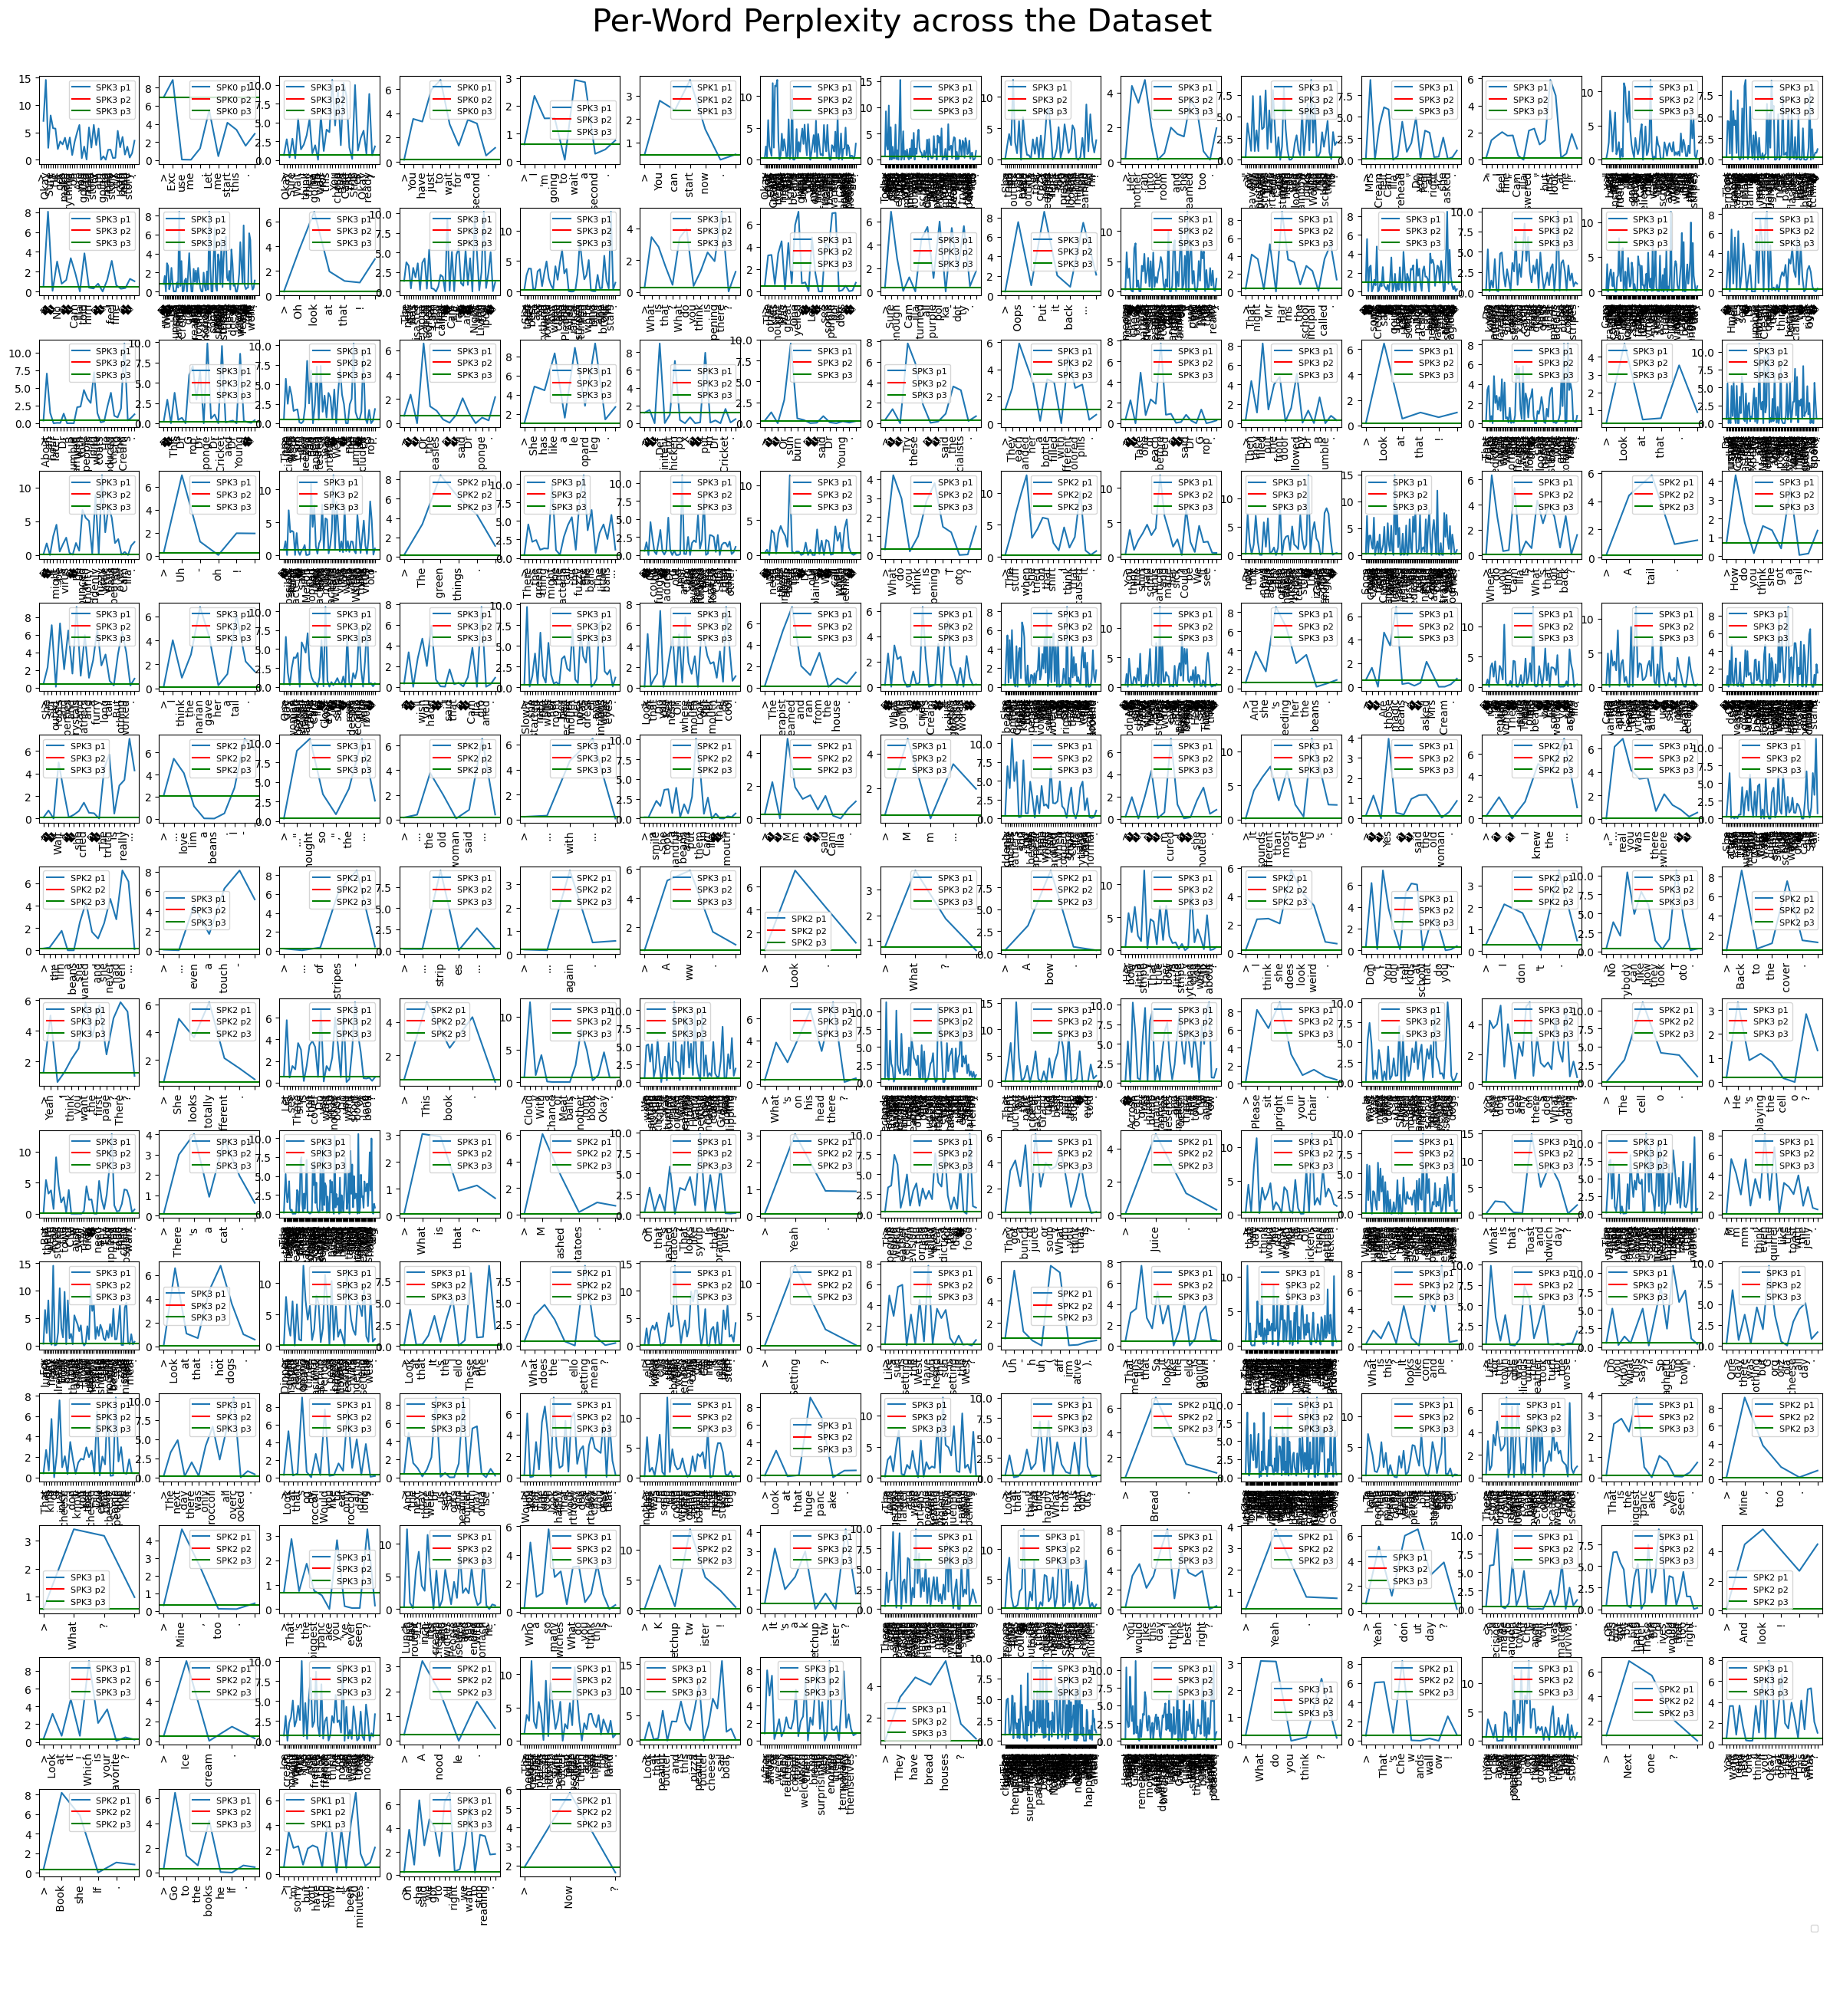

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

KeyboardInterrupt



In [15]:
dominance = {}
for content, name in zip(dami2pc_df["file_content"], dami2pc_df["file_name"]):
    dominance[name] = {}
    pattern = '<(SPK[0-9]|MOD)>'
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    content = [re.sub(pattern,">", d) for d in content]
    assert len(perplexity_scores_p1[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
    tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
    assert len(torch.cat(tokens)) == len(perplexity_scores_p1[name])
    compute_graph_perplexity(tokens, perplexity_scores_p1[name],[np.nan for _ in range(len(perplexity_scores_p1[name]))],matches, pattern=pattern) 

In [14]:
import difflib

def visualize_string_diff(str1, str2):
    # Create a Differ object
    differ = difflib.Differ()
    
    # Compute the difference between the two strings
    diff = differ.compare(str1.splitlines(), str2.splitlines())
    
    # Join the differences with newline for visualization
    diff_str = '\n'.join(diff)
    
    return diff_str

In [15]:
import glob
path = '/u/sebono/conversational_dominance/data/processed/DAMI-P2C/parent-child-annotated/'
name="p20_s1_vid_parent_annotation_2019-04-18-14-30-24"

content = dami2pc_df[dami2pc_df["file_name"] == name]["file_content"][0]
pattern = '<(SPK[0-9]|MOD)>'
matches = re.findall(pattern, "".join(content))
content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
content = [re.sub(pattern,">", d) for d in content]
assert len(perplexity_scores_p3[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)

In [16]:
from transformers import GPT2Tokenizer

# Initialize the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
bin_width = 5


def compute_bins(content, t_u):
    
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    bin_width = 5
    
    len_per_token = [len(tokenizer(dialogue, return_tensors="pt").input_ids[0].detach().numpy()) for dialogue in content]
    tokens = [tokenizer(dialogue, return_tensors="pt").input_ids[0].detach().numpy() for dialogue in content]
    time_per_token = []
  
    for idx in range(len(content)):   
        if len(tokens[idx]) == 0:
            time_per_token.append(0)
        else:
            time_per_token.append(t_u[idx] / len(tokens[idx]))

    all_tokens = []
    for dialogue in content:
        all_tokens += list(tokenizer(dialogue, return_tensors="pt").input_ids[0].detach().numpy())

    all_tokens = np.asarray(all_tokens)
    assert len(all_tokens) == np.asarray(len_per_token).sum()
    assert len(len_per_token) == len(time_per_token)

    elements = [(count, value) for count, value in zip(len_per_token, time_per_token)]
    arr = sum([[val] * num for num, val in elements], [])
    data = np.asarray(arr).cumsum()

    bin_edges = np.arange(0, np.ceil(data.max()) + bin_width, bin_width)

    idx_bin = np.digitize(data, bin_edges)
    unique_bins = np.unique(idx_bin)
    assert len(all_tokens) == len(idx_bin)
    return idx_bin

In [18]:
from transformers import GPT2Tokenizer

# Initialize the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
bin_width = 5

In [19]:
def create_mask(arr):
    transformed_arr = []
    for num in arr:
        if num == 0:
            transformed_arr.append(0)
        else:
            transformed_arr.extend([1] * num)
    return np.asarray(transformed_arr, dtype=np.int64).cumsum() - 1

def compute_per_utterance_mean_perplexity(dialog, tokens, perpl, matches, pattern = '<(SPK[1-9]|MOD)>'):
    
    masked_speakers = []
    encodings = torch.cat(tokens)    
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    warnings.filterwarnings("ignore", message="Mean of empty slice")

    pos_nxt_speaker_token = np.asarray([0] + [len(tokenizer(d, return_tensors="pt").input_ids[0]) for d in dialog])
    pos_nxt_speaker_token_cumsum = pos_nxt_speaker_token.cumsum()
    bin_edges = np.concatenate([[0], tokens_ids_per_sentence])
    idx_bin = np.digitize(pos_nxt_speaker_token_cumsum, bin_edges) - 1

    assert len(idx_bin) - 1 == len(dialog)
    assert len(pos_nxt_speaker_token_cumsum) - 1 == len(dialog)

    prev_idx_pp = 0
    utterance_to_ppl = []
    current_sum = 0
    nxs_spk = []
    substring_ppl_ls = []
    utterance_to_ppl_sent = []
    
    for idx in range(len(tokens)):
        idxs_nxt_speaker_token = pos_nxt_speaker_token_cumsum[np.argwhere(np.isin(idx_bin, idx)).flatten()] - prev_idx_pp
        idx_pp = tokens_ids_per_sentence[idx]
        encodings_ = encodings[prev_idx_pp:idx_pp]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        substring_ppl = [np.nanmean(perpl_per_sent[start:end]) for start, end in zip([0] + list(idxs_nxt_speaker_token), list(idxs_nxt_speaker_token) + [None])]
        substrings_detoken = [encodings_[start:end] for start, end in zip([0] + list(idxs_nxt_speaker_token), list(idxs_nxt_speaker_token) + [None])] 
        substring_ppl_ls = [substring_ppl[num] for num, s in enumerate(substrings_detoken) if s.numel() != 0]
        utterance_to_ppl.append(substring_ppl_ls)     
        utterance_to_ppl_sent.append([tokenizer.decode(token, skip_special_tokens=True) for token in substrings_detoken])
        prev_idx_pp = idx_pp
        
        if len(idxs_nxt_speaker_token)>0 and len(substring_ppl_ls) != len(idxs_nxt_speaker_token):
            nxs_spk.append(0)
        nxs_spk.append(len(idxs_nxt_speaker_token))

    return  utterance_to_ppl, utterance_to_ppl_sent, create_mask(nxs_spk)

In [20]:
import glob 

def compute_dominance_ppl(perplexity_scores):
    directory = "/u/sebono/conversational_dominance/data/external/DAMI-P2C/"
    
    dominance_p = {}
    dominance_p_decoded_sent = {}
    
    for content, name in zip(dami2pc_df["file_content"], dami2pc_df["file_name"]):
        if name not in perplexity_scores:
            continue
        dominance_p[name] = {}
        dominance_p_decoded_sent[name] = {}
        print(f"trying {name}")
        filepath = glob.os.path.join(directory, name) + ".csv"
        d = pd.read_csv(filepath)
        d_to_t = [d["video-timestamp-elapsed time"][i] - d["video-timestamp-elapsed time"][i-1] for i in range(1, len(d["video-timestamp-elapsed time"]))]+[np.asarray(d["video-timestamp-elapsed time"])[-1] - np.asarray(d["video-timestamp-elapsed time"])[-2]]
        pattern = '<(SPK[0-9]|MOD)>'
        matches = np.asarray(re.findall(pattern, "".join(content)))
        content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
        content = [re.sub(pattern,">", d) for d in content]
        assert len(content) == len(matches)
        try:
            assert len(content) == len(d_to_t)
        except:
            continue
        assert len(matches) == len(content)
        idx_bin = compute_bins(content, d_to_t)
        assert len(perplexity_scores[name]) == tokenizer(" ".join(content), return_tensors="pt").input_ids.size(1)
        assert len(idx_bin) == tokenizer(" ".join(content), return_tensors="pt").input_ids.size(1)
        unique_bins = np.unique(idx_bin)
        encodings = tokenizer(" ".join(content), return_tensors="pt").input_ids.ravel()
        tokens = [tokenizer(token, return_tensors="pt").input_ids[0] for token in content]
        result_list = []
        for i in range(1, unique_bins[-1]+1):
            if i in unique_bins:
                result_list += torch.tensor([encodings[idx_bin == i].tolist()])
            else:
                result_list += torch.tensor([])
        len_tokens = np.asarray([len(d) for d in tokens]).cumsum()
        result, result_decoded_sent, nxs_spk = compute_per_utterance_mean_perplexity(content,result_list,perplexity_scores[name], matches)

        idx=0
        for t, (elms,elms_decoded_sent) in enumerate(zip(result,result_decoded_sent)):
            dominance_p[name][t] = {}
            dominance_p_decoded_sent[name][t] = {}
            for c, (a,b) in zip(elms_decoded_sent, zip(matches[nxs_spk][idx:idx + len(elms)],elms)):
                if a not in dominance_p[name][t]:
                    dominance_p[name][t][a] = []
                    dominance_p_decoded_sent[name][t][a] = []
                dominance_p[name][t][a].append(b)
                dominance_p_decoded_sent[name][t][a].append(c)

            for k in dominance_p[name][t].keys():
                dominance_p[name][t][k] = np.mean(dominance_p[name][t][k])
            idx+=len(elms)
            
    return dominance_p,dominance_p_decoded_sent

In [21]:
dominance_p1,dominance_p_decoded_sent_p1 = compute_dominance_ppl(perplexity_scores_p1)
dominance_p3,dominance_p_decoded_sent_p3 = compute_dominance_ppl(perplexity_scores_p3)

trying p20_s1_vid_parent_annotation_2019-04-18-14-30-24


Token indices sequence length is longer than the specified maximum sequence length for this model (5556 > 1024). Running this sequence through the model will result in indexing errors


trying p09_s1_vid_parent_annotation_2019-03-16-09-49-32
trying p06_s1_vid_parent_annotation_2019-03-09-14-18-01
trying p28_s1_vid_parent_annotation_2019-04-28-14-17-57
trying p14_s1_vid_parent_annotation_2019-03-23-15-38-30
trying p01_s2_vid_parent_annotation_2019-03-13-11-16-16
trying p26_s1_vid_parent_annotation_2019-04-23-10-04-57
trying p15_s1_vid_parent_annotation_2019-03-24-11-21-48
trying p06_s2_vid_parent_annotation_2019-03-17-13-41-16
trying p02_s1_vid_parent_annotation_2019-03-08-11-56-48
trying p19_s2_vid_parent_annotation_2019-04-14-14-51-21
trying p20_s2_vid_parent_annotation_2019-04-28-11-55-07
trying p22_s1_vid_parent_annotation_2019-04-18-19-11-20
trying p23_s2_vid_parent_annotation_2019-04-20-18-02-02
trying p32_s1_vid_parent_annotation_2019-05-18-11-06-50
trying p08_s2_vid_parent_annotation_2019-03-21-18-39-44
trying p18_s2_vid_parent_annotation_2019-04-08-19-11-29
trying p24_s1_vid_parent_annotation_2019-04-18-09-52-26
trying p24_s2_vid_parent_annotation_2019-04-21-0

In [35]:
path = "/u/sebono/conversational_dominance/data/processed/DAMI-P2C/"
with open(f'{path}/dominance_p1.pkl', 'wb') as f:
    pickle.dump(dominance_p1, f)
with open(f'{path}/dominance_p3.pkl', 'wb') as f:
    pickle.dump(dominance_p3, f)

### Starting Analysis

In [10]:
import pandas as pd

In [11]:
import pickle
path = "/u/sebono/conversational_dominance/data/processed/DAMI-P2C/"
with open(f'{path}/dominance_p1.pkl', 'rb') as f:
    dominance_p1 = pickle.load(f)
with open(f'{path}/dominance_p3.pkl', 'rb') as f:
    dominance_p3 = pickle.load(f)

In [2]:
len(list(dominance_p3.keys())), len(list(dominance_p1.keys()))

(65, 65)

In [9]:
perplexity_scores_p1[name]

NameError: name 'perplexity_scores_p1' is not defined

In [5]:
key = list(dominance_p3.keys())[0]
directory = "/u/sebono/conversational_dominance/data/external/DAMI-P2C/"
pd.read_csv(directory + key + ".csv").shape, len(dominance_p3[key].keys())

((200, 8), 277)

In [91]:
pd.read_csv(directory + key + ".csv")[20:80]

Unnamed: 0    speaker               elapsed_time  \
20          20      child  0 days 00:00:59.000000000   
21          21     parent  0 days 00:01:02.000000000   
22          22  Speaker 3  0 days 00:01:06.000000000   
23          23     parent  0 days 00:01:11.000000000   
24          24      child  0 days 00:01:14.000000000   
25          25     parent  0 days 00:01:15.000000000   
26          26  Speaker 3  0 days 00:01:17.000000000   
27          27     parent  0 days 00:01:18.000000000   
28          28      child  0 days 00:01:18.000000000   
29          29     parent  0 days 00:01:20.000000000   
30          30      child  0 days 00:01:21.000000000   
31          31     parent  0 days 00:01:25.000000000   
32          32      child  0 days 00:01:29.000000000   
33          33     parent  0 days 00:01:29.000000000   
34          34     parent  0 days 00:01:31.000000000   
35          35      child  0 days 00:01:33.000000000   
36          36     parent  0 days 00:01:33.000000000   
37          37      child  0 days 00:01:36.000000000   
38          38     parent  0 days 00:01:39.000000000   
39          39      child  0 days 00:01:41.000000000   
40          40     parent  0 days 00:01:46.000000000   
41          41      child  0 days 00:01:47.000000000   
42          42     parent  0 days 00:01:52.000000000   
43          43     parent  0 days 00:01:57.000000000   
44          44      child  0 days 00:01:58.000000000   
45          45     parent  0 days 00:01:58.000000000   
46          46      child  0 days 00:01:59.000000000   
47          47     parent  0 days 00:02:00.000000000   
48          48      child  0 days 00:02:04.000000000   
49          49     parent  0 days 00:02:04.000000000   
50          50      child  0 days 00:02:08.000000000   
51          51     parent  0 days 00:02:11.000000000   
52          52      child  0 days 00:02:11.000000000   
53          53     parent  0 days 00:02:20.000000000   
54          54      child  0 days 00:02:21.000000000   
55          55     parent  0 days 00:02:27.000000000   
56          56      child  0 days 00:02:33.000000000   
57          57     parent  0 days 00:02:36.000000000   
58          58      child  0 days 00:02:37.000000000   
59          59     parent  0 days 00:02:38.000000000   
60          60      child  0 days 00:02:43.000000000   
61          61     parent  0 days 00:02:47.000000000   
62          62      child  0 days 00:02:48.000000000   
63          63     parent  0 days 00:02:48.000000000   
64          64      child  0 days 00:02:48.000000000   
65          65     parent  0 days 00:02:48.000000000   
66          66      child  0 days 00:02:48.000000000   
67          67     parent  0 days 00:02:50.000000000   
68          68      child  0 days 00:02:54.000000000   
69          69     parent  0 days 00:02:55.000000000   
70          70      child  0 days 00:02:59.000000000   
71          71     parent  0 days 00:03:00.000000000   
72          72     parent  0 days 00:03:03.000000000   
73          73      child  0 days 00:03:04.000000000   
74          74     parent  0 days 00:03:06.000000000   
75          75      child  0 days 00:03:08.000000000   
76          76      child  0 days 00:03:10.000000000   
77          77     parent  0 days 00:03:15.000000000   
78          78      child  0 days 00:03:17.000000000   
79          79     parent  0 days 00:03:18.000000000   

                                              content  \
20                   How do we get to the first page?   
21  How do we get to the second page? No, it's not...   
22                                  It's not working?   
23                    No. It won't get to the second-   
24                                        First page.   
25             -page. It won't go to the second page.   
26                       Oh, you just tap it up here.   
27                                           Oh okay.   
28                                                Oh.   
29  Yay, here we 

In [26]:
def speaker_ids(names):
    d_names = []
    re_names = []
    for id, re_n in enumerate(names):
        n = f"SPK{id}"
        re_names.append(re_n)
        d_names.append(n)
    return dict(zip(re_names,d_names))

import os
import pandas as pd
import numpy as np
import re
# List to hold the dataframes
dialogues = []
dialogues_ids = []
timestamps=[]
d_to_t = []
t_to_d = []
users = []
maps = {}
directory = "/u/sebono/conversational_dominance/data/external/DAMI-P2C/"
# Iterate over all CSV files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        d = pd.read_csv(filepath)
        utterances = d["content"]
        speakers = np.unique(np.asarray(d["speaker"]))
        map_names = speaker_ids(speakers)
        dialogues_ids.append(filename.replace(".csv",""))
        maps[filename.replace(".csv","")] = map_names

In [27]:
dominance_p3

{'p20_s1_vid_parent_annotation_2019-04-18-14-30-24': {0: {'SPK3': 0.0},
  1: {'SPK3': 0.0},
  2: {'SPK3': 0.0},
  3: {'SPK3': 0.3420828878879547, 'SPK0': 6.928652763366699},
  4: {'SPK3': 0.6841657757759094},
  5: {'SPK3': 0.6841657757759094},
  6: {'SPK3': 0.6841657757759094},
  7: {'SPK3': 0.6841657757759094, 'SPK0': 0.17056599259376526},
  8: {'SPK0': 0.17056599259376526,
   'SPK3': 0.4460291266441345,
   'SPK1': 0.46320974826812744},
  9: {'SPK3': 0.28404897451400757},
  10: {'SPK3': 0.28404897451400757},
  11: {'SPK3': 0.28404897451400757},
  12: {'SPK3': 0.46588456630706787},
  13: {'SPK3': 0.6477201581001282},
  14: {'SPK3': 0.6477201581001282},
  15: {'SPK3': 0.6477201581001282},
  16: {'SPK3': 0.6477201581001282},
  17: {'SPK3': 0.3988566920161247},
  18: {'SPK3': 0.14999322593212128},
  19: {'SPK3': 0.14999322593212128},
  20: {'SPK3': 0.17921970784664154},
  21: {'SPK3': 0.2963967025279999},
  22: {'SPK3': 0.2963967025279999},
  23: {'SPK3': 0.2963967025279999},
  24: {'SPK3

In [28]:
maps

{'p20_s1_vid_parent_annotation_2019-04-18-14-30-24': {'Speaker 2': 'SPK0',
  'Speaker 3': 'SPK1',
  'child': 'SPK2',
  'parent': 'SPK3'},
 'p09_s1_vid_parent_annotation_2019-03-16-09-49-32': {'Speaker 2': 'SPK0',
  'Speaker 4': 'SPK1',
  'child': 'SPK2',
  'parent': 'SPK3'},
 'p06_s1_vid_parent_annotation_2019-03-09-14-18-01': {'Speaker 1': 'SPK0',
  'child': 'SPK1',
  'parent': 'SPK2'},
 'p28_s1_vid_parent_annotation_2019-04-28-14-17-57': {'Speaker 1': 'SPK0',
  'Speaker 4': 'SPK1',
  'child': 'SPK2',
  'parent': 'SPK3'},
 'p14_s1_vid_parent_annotation_2019-03-23-15-38-30': {'Speaker 3': 'SPK0',
  'child': 'SPK1',
  'parent': 'SPK2'},
 'p01_s2_vid_parent_annotation_2019-03-13-11-16-16': {'Speaker 3': 'SPK0',
  'child': 'SPK1',
  'parent': 'SPK2'},
 'p26_s1_vid_parent_annotation_2019-04-23-10-04-57': {'Interviever': 'SPK0',
  'child': 'SPK1',
  'parent': 'SPK2'},
 'p15_s1_vid_parent_annotation_2019-03-24-11-21-48': {'Speaker 2': 'SPK0',
  'Speaker 4': 'SPK1',
  'child': 'SPK2',
  'pare

In [29]:
def ppl_lists(maps, dominance_p1):
    child = maps[key]["child"]
    parent = maps[key]["parent"]

    child_list = []
    parent_list = []

    for t in dominance_p1.keys():
        if child in dominance_p1[t]:
            child_list.append(dominance_p1[t][child])
        else:
            child_list.append(np.nan)
        if parent in dominance_p1[t]:
            parent_list.append(dominance_p1[t][parent])
        else:
            parent_list.append(np.nan)
    return parent_list, child_list 

In [35]:
def ppl_list(maps, dominance_p1, child_val, par_val, child_ars, par_ars):
    child = maps[key]["child"]
    parent = maps[key]["parent"]
    
    spk_list = []
    ppl_list = []
    ars_list = []
    val_list = []
    
    for t in dominance_p1.keys():
        for spk in dominance_p1[t]:
            if spk == child:
                ppl_list.append(dominance_p1[t][child])
                ars_list.append(child_ars[t])
                val_list.append(child_val[t])
                spk_list.append(child)
            if spk == parent:
                ppl_list.append(dominance_p1[t][parent])
                ars_list.append(par_ars[t])
                val_list.append(par_val[t])
                spk_list.append(parent)
        
    return spk_list, ppl_list, ars_list, val_list

In [36]:
import os
import glob
import pandas as pd
import numpy as np

path_annotations = "/u/sebono/conversational_dominance/data/processed/DAMI-P2C/parent-child(affect-labels)-april9/"
final_df = pd.DataFrame([])

for key in dominance_p3.keys():
    annotations = glob.glob(os.path.join(path_annotations, key + "*.csv"))
    exit
    if annotations == []:
        continue
    data_lists = [pd.read_csv(file)[["PARENT's valence", "CHILD's valence", "PARENT's arousal", "CHILD's arousal"]].to_numpy() for file in annotations]
    averages = np.asarray([sum(values) / len(values) for values in zip(*data_lists)])[:len(dominance_p3[key])]
    try:
        assert pd.DataFrame(averages).shape[0] == len(dominance_p3[key])
        assert len(dominance_p3[key]) == len(dominance_p1[key])
    except:
        print(key)
        print(pd.DataFrame(averages).shape[0], len(dominance_p3[key]))
        continue
    parent_list_p1, child_list_p1 = ppl_lists(maps, dominance_p1[key])
    parent_list_p3, child_list_p3 = ppl_lists(maps, dominance_p3[key])
    
    df = pd.DataFrame({"parent_p1":parent_list_p1, "parent_p3":parent_list_p3,"child_p1":child_list_p1,"child_p3":child_list_p3, "PARENT's valence":averages[:,0], "CHILD's valence":averages[:,1], "PARENT's arousal":averages[:,2], "CHILD's arousal": averages[:,3]})

    
    
    final_df = pd.concat([final_df, df], axis=0).dropna()

p14_s1_vid_parent_annotation_2019-03-23-15-38-30
269 270
p06_s2_vid_parent_annotation_2019-03-17-13-41-16
251 252
p33_s1_vid_parent_annotation_2019-05-19-10-14-19
244 245
p15_s2_vid_parent_annotation_2019-03-31-13-04-39
297 384


In [64]:
import os
import glob
import pandas as pd
import numpy as np

path_annotations = "/u/sebono/conversational_dominance/data/processed/DAMI-P2C/parent-child(affect-labels)-april9/"
final_df = {}

for key in dominance_p3.keys():
    annotations = glob.glob(os.path.join(path_annotations, key + "*.csv"))
    exit
    if annotations == []:
        continue
    data_lists = [pd.read_csv(file)[["PARENT's valence", "CHILD's valence", "PARENT's arousal", "CHILD's arousal"]].to_numpy() for file in annotations]
    averages = np.asarray([sum(values) / len(values) for values in zip(*data_lists)])[:len(dominance_p3[key])]
    try:
        assert pd.DataFrame(averages).shape[0] == len(dominance_p3[key])
        assert len(dominance_p3[key]) == len(dominance_p1[key])
    except:
        print(key)
        print(pd.DataFrame(averages).shape[0], len(dominance_p3[key]))
        continue
        
    #"PARENT's valence":averages[:,0], "CHILD's valence":averages[:,1], "PARENT's arousal":averages[:,2], "CHILD's arousal": averages[:,3]
    spk_list, ppl_list_p1, ars_list, val_list = ppl_list(maps, dominance_p1[key], averages[:,0], averages[:,1], averages[:,2], averages[:,3])
    spk_list, ppl_list_p3, ars_list, val_list = ppl_list(maps, dominance_p3[key], averages[:,0], averages[:,1], averages[:,2], averages[:,3])
    
    final_df[key] = pd.DataFrame({"speaker": spk_list, "p1":ppl_list_p1, "p3":ppl_list_p3, "arousal": ars_list, "valence":val_list})

p14_s1_vid_parent_annotation_2019-03-23-15-38-30
269 270
p06_s2_vid_parent_annotation_2019-03-17-13-41-16
251 252
p33_s1_vid_parent_annotation_2019-05-19-10-14-19
244 245
p15_s2_vid_parent_annotation_2019-03-31-13-04-39
297 384


In [66]:
keys = list(final_df.keys())

## Looking at correlations

In [67]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import plotly
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)
import seaborn as sns

In [80]:
cmp = 'algae'
def correlation_heatmap(y_cols, x_cols, full_data):
    '''
    Uses scipy.stats.spearmanr function
    Params:
    y_cols, x_cols: sets of column titles (strings)
    full_data: pandas dataframe that includes all columns listed in y_cols, x_cols
    Returns:
    corr: Spearman correlation coefficient matrix (y_cols = rows, x_cols = cols of matrix)
    fig_corr: annotated plotly heatmap of coefficients
    p: Spearman p-value matrix
    fig_p: annotated plotly heatmap of p-values
    '''
    cols = y_cols+x_cols
    all_correlations = scipy.stats.spearmanr(full_data[cols], nan_policy='omit')
    corr = all_correlations.statistic[:len(y_cols), -len(x_cols):]
    corr = pd.DataFrame(corr)
    corr.columns = x_cols
    corr.index = y_cols

    p = all_correlations.pvalue[:len(y_cols), -len(x_cols):]
    p = pd.DataFrame(p)
    p.columns = x_cols
    p.index = y_cols
    
    fig_corr = px.imshow(corr, text_auto=True, aspect='auto', color_continuous_scale='agsunset')
    #fig_r2 = px.imshow(corr**2, text_auto=True, aspect='auto', color_continuous_scale='agsunset')
    fig_p = px.imshow(p, text_auto=True, aspect='auto', color_continuous_scale='gray_r')

    return corr, fig_corr, p, fig_p, fig_r2

In [81]:
def correlation(df_final):
    corr, fig_corr, p, fig_p, fig_r2 = correlation_heatmap(col_1, col_2, df_final)
    fig_corr.show()
    fig_p.show()
    fig_r2.show()
    return corr, fig_corr, p, fig_p, fig_r2

In [82]:
#affective_states = ["PARENT's valence", "PARENT's arousal", "CHILD's valence", "CHILD's arousal"]
#cognitive_states = ["parent_p1", "parent_p3", "child_p1", "child_p3"]
affective_states = ['valence', 'arousal']
cognitive_states = ['p1','p3']

In [84]:
col_1 = affective_states
col_2 = cognitive_states
for n in range(0,len(keys)):
    print("--------------")
    corr, fig_corr, p, fig_p, fig_r2 = correlation(final_df[keys[n]])

--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


--------------


TypeError: 'float' object is not subscriptable

In [78]:
keys

['p20_s1_vid_parent_annotation_2019-04-18-14-30-24',
 'p09_s1_vid_parent_annotation_2019-03-16-09-49-32',
 'p06_s1_vid_parent_annotation_2019-03-09-14-18-01',
 'p28_s1_vid_parent_annotation_2019-04-28-14-17-57',
 'p01_s2_vid_parent_annotation_2019-03-13-11-16-16',
 'p26_s1_vid_parent_annotation_2019-04-23-10-04-57',
 'p15_s1_vid_parent_annotation_2019-03-24-11-21-48',
 'p02_s1_vid_parent_annotation_2019-03-08-11-56-48',
 'p19_s2_vid_parent_annotation_2019-04-14-14-51-21',
 'p20_s2_vid_parent_annotation_2019-04-28-11-55-07',
 'p22_s1_vid_parent_annotation_2019-04-18-19-11-20',
 'p32_s1_vid_parent_annotation_2019-05-18-11-06-50',
 'p18_s2_vid_parent_annotation_2019-04-08-19-11-29',
 'p24_s1_vid_parent_annotation_2019-04-18-09-52-26',
 'p31_s1_vid_parent_annotation_2019-05-10-20-30-06',
 'p25_s2_vid_parent_annotation_2019-04-30-12-40-13',
 'p31_s2_vid_parent_annotation_2019-05-17-20-12-56',
 'p34_s2_vid_parent_annotation_2019-06-01-13-37-58',
 'p05_s1_vid_parent_annotation_2019-03-09-12-5